# Libraries Import

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image

In [2]:
# ---------------------------
# 1. Dataset Loading & Preprocessing
# ---------------------------
# We use an ImageFolder dataset for CIFAR-10 images stored in folders.
# For this project we filter to only include the "cat" and "dog" classes.
dataset_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/train"
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # Normalize to [-1, 1]
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
# Load the full dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
# Get indices for only "cat" and "dog"
selected_classes = ['cat', 'dog']
selected_indices = [i for i, (path, label) in enumerate(full_dataset.samples)
                    if full_dataset.classes[label] in selected_classes]
dataset = Subset(full_dataset, selected_indices)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

test_dataset_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/test"

# Use the same transform as for training.
test_full_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)

# Filter test dataset to include only "cat" and "dog" classes.
selected_classes = ['cat', 'dog']
test_selected_indices = [i for i, (path, label) in enumerate(test_full_dataset.samples)
                         if test_full_dataset.classes[label] in selected_classes]

test_dataset = Subset(test_full_dataset, test_selected_indices)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Test dataset loaded with {len(test_dataset)} samples.")

Using device: cuda
Test dataset loaded with 2000 samples.


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=150, feature_map_size=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: (latent_dim) x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            # State: (feature_map_size*8) x 4 x 4
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            # State: (feature_map_size*4) x 8 x 8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            # State: (feature_map_size*2) x 16 x 16
            nn.ConvTranspose2d(feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),
            # State: (feature_map_size) x 32 x 32
            nn.ConvTranspose2d(feature_map_size, 3, 3, 1, 1, bias=False),
            nn.Tanh()  # Output is in the range [-1, 1]
        )
    
    def forward(self, z):
        return self.net(z)
        
alpha_new = 1e-4                    # Lower scaling factor for the similarity score.
# Siamese Discriminator: Extract features from images and compute a similarity score.
class SiameseDiscriminator(nn.Module):
    def __init__(self, feature_map_size=64, alpha=1e-5):  # Reduced alpha from 1e-4 to 1e-5
        super(SiameseDiscriminator, self).__init__()
        self.alpha = alpha
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, feature_map_size, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size*2, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size*2, feature_map_size*4, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
    def forward(self, img1, img2):
        f1 = self.feature_extractor(img1)
        f2 = self.feature_extractor(img2)
        f1 = f1.view(f1.size(0), -1)
        f2 = f2.view(f2.size(0), -1)
        diff = f1 - f2
        dist_sq = torch.sum(diff**2, dim=1, keepdim=True)
        score = torch.exp(-self.alpha * dist_sq)
        return score

In [4]:
# ---------- 2.2 VAE Components -----------
class VAE(nn.Module):
    def __init__(self, latent_dim=512, feature_map_size=64):
        super(VAE, self).__init__()
        # Encoder: Input (3, 32, 32), output latent vector parameters
        self.encoder = nn.Sequential(
            nn.Conv2d(3, feature_map_size, 4, 2, 1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(feature_map_size, feature_map_size*2, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(feature_map_size*2),
            nn.ReLU(),
            nn.Conv2d(feature_map_size*2, feature_map_size*4, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(feature_map_size*4),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.feature_dim = feature_map_size*4*4*4  # Final feature map flattened
        self.fc_mu = nn.Linear(self.feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.feature_dim, latent_dim)
        
        # Decoder: Map latent vector to image
        self.fc_decode = nn.Linear(latent_dim, self.feature_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (feature_map_size*4, 4, 4)),
            nn.ConvTranspose2d(feature_map_size*4, feature_map_size*2, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size*2),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size*2, feature_map_size, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size, 3, 4, 2, 1),
            nn.Tanh()  # Output in [-1,1]
        )
        
    def encode(self, x):
        x_enc = self.encoder(x)
        x_enc = self.flatten(x_enc)
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [5]:
# ---------------------------
# 3. Loss Functions and Hyperparameters
# ---------------------------
# ----- For GAN using Minmax Loss (with similarity score) -----
epsilon = 1e-8  # To avoid log(0)
# For a given pair, D(x, y) is our similarity score as computed by SiameseDiscriminator.
# Define the minmax losses:
# For discriminator:

# --- LS-GAN Losses (unchanged) ---
def ls_gan_discriminator_loss(D_real, D_fake):
    loss_real = torch.mean((D_real - 1.0)**2)
    loss_fake = torch.mean(D_fake**2)
    return 0.5 * (loss_real + loss_fake)

def ls_gan_generator_loss(D_fake):
    return 0.5 * torch.mean((D_fake - 1.0)**2)

# --- Hyperparameters ---


In [6]:
# ----- For VAE: -----
# Use L1 loss (for sharper output) and KL divergence.
def vae_loss(recon, x, mu, logvar, kl_weight=0.01):
    recon_loss = nn.functional.l1_loss(recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss, recon_loss, kl_loss

# Updated hyperparameters for the GAN:
gan_latent_dim = 150
lr_gen = 1e-4      # Generator LR - might experiment with increasing slightly (e.g. 2e-4)
lr_disc = 1e-5     # Discriminator LR - already very low
beta1 = 0.5

# Hyperparameters for VAE
vae_latent_dim = 512            # You can experiment with even larger if your hardware allows.
lr_vae = 1e-5                   # Slightly increased learning rate from the previous very low rate.
kl_weight_new = 0.001           # Lower the KL divergence weight to let reconstructions be sharper.

# Use the same VAE architecture defined previously.
# In your VAE loss, update the weight:
def vae_loss(recon, x, mu, logvar, kl_weight=kl_weight_new):
    recon_loss = nn.functional.l1_loss(recon, x, reduction='sum')  # L1 loss tends to yield sharper images.
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss, recon_loss, kl_loss

In [7]:
# ---------------------------
# 4. Initialize Models and Optimizers
# ---------------------------
generator = Generator(latent_dim=gan_latent_dim).to(device)
discriminator = SiameseDiscriminator(alpha=1e-5).to(device)

optimizerG = optim.Adam(generator.parameters(), lr=lr_gen, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(beta1, 0.999))

# Optionally, define schedulers here if needed.
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=50, gamma=0.5)
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=50, gamma=0.5)


# VAE Model
vae = VAE(latent_dim=vae_latent_dim).to(device)
optimizerVAE = optim.Adam(vae.parameters(), lr=lr_vae)


In [8]:
# --- Training Loop ---
gan_loss_history = {"G": [], "D": []}
num_epochs = 400

print("Starting GAN Training with Revised Settings...")

# Adversarial update schedule: Every 4th epoch update discriminator, others update generator only.
for epoch in range(1, num_epochs + 1):
    update_discriminator = (epoch % 4 == 0)
    
    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)
        
        # Generator forward pass: generate fake images from random noise.
        noise = torch.randn(batch_size, gan_latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        
        # --- Discriminator Update ---
        if update_discriminator:
            D_real = discriminator(real_imgs, real_imgs)   # Target: ~1
            D_fake = discriminator(real_imgs, fake_imgs.detach())  # Target: ~0
            
            optimizerD.zero_grad()
            loss_D = ls_gan_discriminator_loss(D_real, D_fake)
            loss_D.backward()
            optimizerD.step()
            gan_loss_history["D"].append(loss_D.item())
        else:
            gan_loss_history["D"].append(gan_loss_history["D"][-1] if gan_loss_history["D"] else 0)
        
        # --- Generator Update (every iteration) ---
        noise = torch.randn(batch_size, gan_latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        D_fake = discriminator(real_imgs, fake_imgs)
        
        optimizerG.zero_grad()
        loss_G = ls_gan_generator_loss(D_fake)
        loss_G.backward()
        optimizerG.step()
        gan_loss_history["G"].append(loss_G.item())
        
        if i % 100 == 0:
            d_msg = f"Loss_D: {loss_D.item():.4f}" if update_discriminator else "(D skipped)"
            print(f"[GAN] Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] Loss_G: {loss_G.item():.4f} {d_msg}")
    
    # Optionally, save sample outputs for each epoch.
    sample_folder_gan = "gan_samples"
    os.makedirs(sample_folder_gan, exist_ok=True)
    with torch.no_grad():
        # Use up to 5 samples if available.
        num_samples = min(5, real_imgs.size(0))
        real_sample = real_imgs[:num_samples]
        noise_sample = torch.randn(num_samples, gan_latent_dim, 1, 1, device=device)
        fake_sample = generator(noise_sample)
        
        grid = torchvision.utils.make_grid(torch.cat([real_sample, fake_sample], dim=0), nrow=num_samples, normalize=True)
        save_image(grid, os.path.join(sample_folder_gan, f"epoch_{epoch}.png"))
    
    # Uncomment to step LR schedulers if defined:
    schedulerG.step()
    schedulerD.step()

print("GAN Training Completed.")


Starting GAN Training with Revised Settings...
[GAN] Epoch [1/400] Batch [0/157] Loss_G: 0.0005 (D skipped)
[GAN] Epoch [1/400] Batch [100/157] Loss_G: 0.0003 (D skipped)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[GAN] Epoch [2/400] Batch [0/157] Loss_G: 0.0003 (D skipped)
[GAN] Epoch [2/400] Batch [100/157] Loss_G: 0.0003 (D skipped)
[GAN] Epoch [3/400] Batch [0/157] Loss_G: 0.0003 (D skipped)
[GAN] Epoch [3/400] Batch [100/157] Loss_G: 0.0003 (D skipped)
[GAN] Epoch [4/400] Batch [0/157] Loss_G: 0.0003 Loss_D: 0.4772
[GAN] Epoch [4/400] Batch [100/157] Loss_G: 0.0006 Loss_D: 0.4679
[GAN] Epoch [5/400] Batch [0/157] Loss_G: 0.0006 (D skipped)
[GAN] Epoch [5/400] Batch [100/157] Loss_G: 0.0004 (D skipped)
[GAN] Epoch [6/400] Batch [0/157] Loss_G: 0.0004 (D skipped)
[GAN] Epoch [6/400] Batch [100/157] Loss_G: 0.0004 (D skipped)
[GAN] Epoch [7/400] Batch [0/157] Loss_G: 0.0004 (D skipped)
[GAN] Epoch [7/400] Batch [100/157] Loss_G: 0.0004 (D skipped)
[GAN] Epoch [8/400] Batch [0/157] Loss_G: 0.0004 Loss_D: 0.4737
[GAN] Epoch [8/400] Batch [100/157] Loss_G: 0.0007 Loss_D: 0.4663
[GAN] Epoch [9/400] Batch [0/157] Loss_G: 0.0008 (D skipped)
[GAN] Epoch [9/400] Batch [100/157] Loss_G: 0.0005 (D skipp

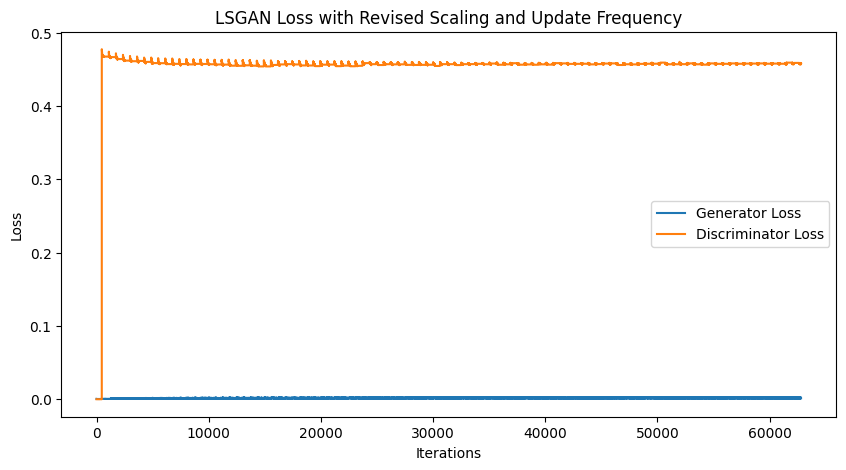

In [9]:
plt.figure(figsize=(10,5))
plt.plot(gan_loss_history["G"], label="Generator Loss")
plt.plot(gan_loss_history["D"], label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("LSGAN Loss with Revised Scaling and Update Frequency")
plt.legend()
plt.show()

In [10]:
# ----- VAE Training Loop -----
vae_loss_history = {"total": [], "recon": [], "kl": []}
num_epochs_vae = 400  # set as needed

print("Starting VAE Training...")
vae.train()
for epoch in range(1, num_epochs_vae+1):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        optimizerVAE.zero_grad()
        recon, mu, logvar = vae(imgs)
        total_loss, recon_loss, kl_loss = vae_loss(recon, imgs, mu, logvar, kl_weight=0.01)
        total_loss.backward()
        optimizerVAE.step()
        
        vae_loss_history["total"].append(total_loss.item())
        vae_loss_history["recon"].append(recon_loss.item())
        vae_loss_history["kl"].append(kl_loss.item())
        
        if i % 100 == 0:
            print(f"[VAE] Epoch [{epoch}/{num_epochs_vae}] Batch [{i}/{len(dataloader)}] Loss: {total_loss.item():.4f} Recon: {recon_loss.item():.4f} KL: {kl_loss.item():.4f}")
    # Optionally save reconstructed samples per epoch
    sample_folder_vae = "vae_samples"
    os.makedirs(sample_folder_vae, exist_ok=True)
    with torch.no_grad():
        recon, _, _ = vae(imgs)
        # Denormalize from [-1, 1] to [0,1]
        imgs_denorm = (imgs + 1) / 2
        recon_denorm = (recon + 1) / 2
        # Build a grid: top row originals, bottom row reconstructions
        n = min(8, imgs.size(0))
        grid_orig = torchvision.utils.make_grid(imgs_denorm[:n], nrow=n)
        grid_recon = torchvision.utils.make_grid(recon_denorm[:n], nrow=n)
        combined = torch.cat([grid_orig, grid_recon], dim=1)
        save_image(combined, os.path.join(sample_folder_vae, f"epoch_{epoch}.png"))
        
print("VAE Training Completed.")

Starting VAE Training...
[VAE] Epoch [1/400] Batch [0/157] Loss: 126457.6797 Recon: 126415.4219 KL: 4225.9209
[VAE] Epoch [1/400] Batch [100/157] Loss: 99691.5703 Recon: 99468.2188 KL: 22334.9570
[VAE] Epoch [2/400] Batch [0/157] Loss: 85792.5391 Recon: 85334.0000 KL: 45853.8906
[VAE] Epoch [2/400] Batch [100/157] Loss: 67699.5469 Recon: 67172.2500 KL: 52729.9727
[VAE] Epoch [3/400] Batch [0/157] Loss: 64434.9375 Recon: 63914.2578 KL: 52068.1016
[VAE] Epoch [3/400] Batch [100/157] Loss: 56132.6875 Recon: 55559.2695 KL: 57341.6133
[VAE] Epoch [4/400] Batch [0/157] Loss: 55671.1172 Recon: 55073.4570 KL: 59766.0391
[VAE] Epoch [4/400] Batch [100/157] Loss: 50613.0430 Recon: 49963.9141 KL: 64912.9180
[VAE] Epoch [5/400] Batch [0/157] Loss: 49433.1797 Recon: 48769.7812 KL: 66339.9219
[VAE] Epoch [5/400] Batch [100/157] Loss: 45845.3438 Recon: 45149.0938 KL: 69624.9062
[VAE] Epoch [6/400] Batch [0/157] Loss: 43509.4766 Recon: 42776.2578 KL: 73321.7109
[VAE] Epoch [6/400] Batch [100/157] Loss

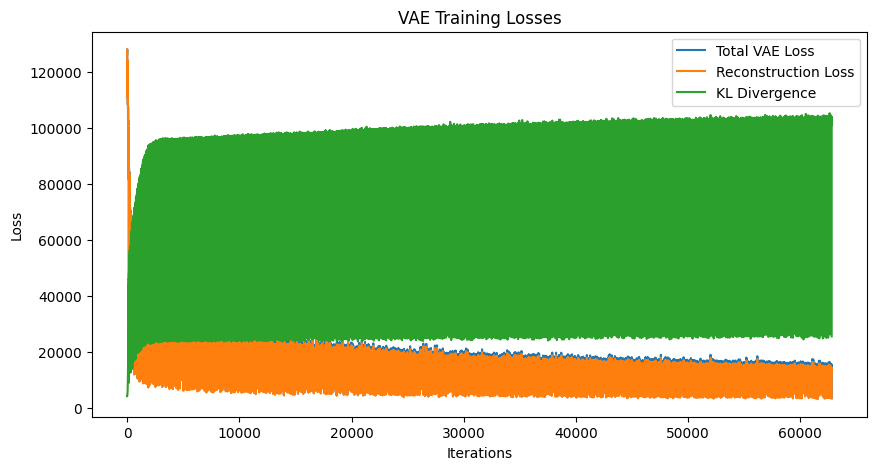

In [11]:
# Plot VAE Loss Curves
plt.figure(figsize=(10,5))
plt.plot(vae_loss_history["total"], label="Total VAE Loss")
plt.plot(vae_loss_history["recon"], label="Reconstruction Loss")
plt.plot(vae_loss_history["kl"], label="KL Divergence")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("VAE Training Losses")
plt.legend()
plt.show()

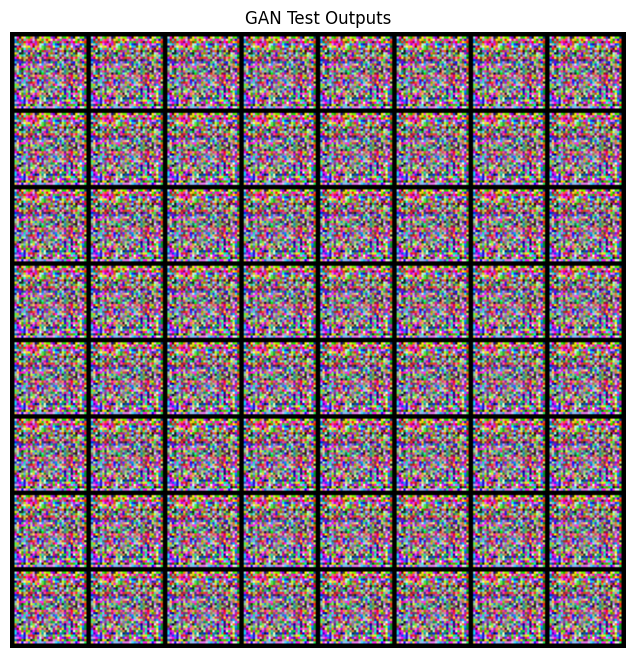

In [12]:
# ----- Testing GAN Outputs on Test Set -----
generator.eval()
with torch.no_grad():
    # Get a batch from the test loader.
    test_batch, _ = next(iter(test_dataloader))
    test_batch = test_batch.to(device)
    noise = torch.randn(test_batch.size(0), gan_latent_dim, 1, 1, device=device)
    fake_test = generator(noise)
    fake_test = (fake_test + 1) / 2  # Denormalize to [0,1]
    grid_test = make_grid(fake_test, nrow=8)
    
    plt.figure(figsize=(8,8))
    plt.title("GAN Test Outputs")
    plt.imshow(np.transpose(grid_test.cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()
    save_image(fake_test, "gan_test_outputs.png", nrow=8, normalize=True)

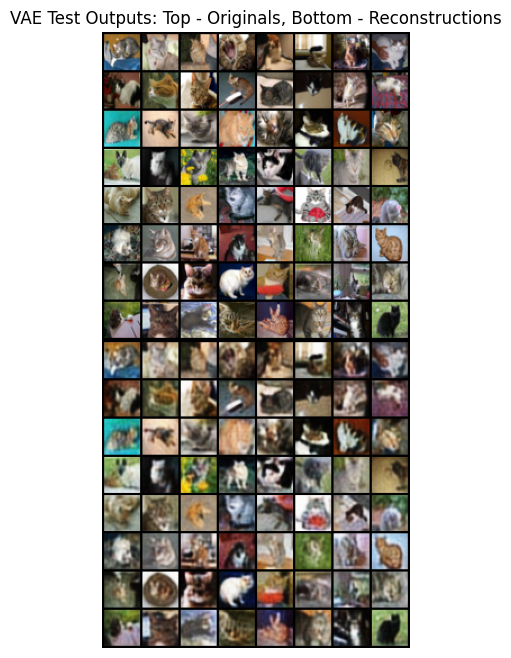

In [13]:
# ----- Testing VAE Outputs on Test Set -----
vae.eval()
with torch.no_grad():
    test_batch, _ = next(iter(test_dataloader))
    test_batch = test_batch.to(device)
    recon_test, _, _ = vae(test_batch)
    test_denorm = (test_batch + 1) / 2
    recon_denorm = (recon_test + 1) / 2
    grid_orig = make_grid(test_denorm, nrow=8)
    grid_recon = make_grid(recon_denorm, nrow=8)
    combined_test = torch.cat([grid_orig, grid_recon], dim=1)
    
    plt.figure(figsize=(16,8))
    plt.title("VAE Test Outputs: Top - Originals, Bottom - Reconstructions")
    plt.imshow(np.transpose(combined_test.cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()
    save_image(combined_test, "vae_test_outputs.png", normalize=True)